<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/advectionDiffusionSource1D_FipyFiniteVolume3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy
# uncomment to install fipy then restart the runtime environment

In [2]:
import numpy as np
from fipy import *

In [3]:
# space discretization
xL = 0.
xR = 0.875 # (km)
delX = xR - xL
nx = 50
dx = delX/nx
mesh = Grid1D(nx=nx, dx=dx) + xL
print('dx (km) = ', dx, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells)

dx (km) =  0.0175 
cellsNbr =  50


In [4]:
# time discretization
# simulation time
delT = 200. # (h)
# advection
Cr = 0.2 # Courant Number: Cr = u*dt/dx
u = 0.0931 # (km/h)
dtAdv = Cr*dx/u
# diffusion
Fr = 0.4 # Fourier Number: Fr = D*dt/dx**2
D = (delX**2)/delT # (km**2/h)
dtDiff = Fr*dx**2/D
# advectionDiffusion
dt = min(dtAdv, dtDiff)

In [5]:
from datetime import timedelta

def timeSTR(time):
    seconds = int(time*3600)
    return str(timedelta(seconds=seconds))

print('dtAdv = ', timeSTR(dtAdv), '\n'
      'dtDiff = ', timeSTR(dtDiff), '\n'
      'dt = min(dtAdv, dtDiff) = ', timeSTR(dt), '\n'
      'delT = ', timeSTR(delT))

dtAdv =  0:02:15 
dtDiff =  0:01:55 
dt = min(dtAdv, dtDiff) =  0:01:55 
delT =  8 days, 8:00:00


In [6]:
# number of time steps
stepsNbr = 200 #int(delT/dt)
print('stepsNbr = ', stepsNbr)

stepsNbr =  200


In [7]:
# the source center is the center of the grid cell the closest
# to the given source position
def sourceCenter(sourcePos):
    global mesh
    x = mesh.x
    xs1 = sourcePos
    dist2Source = DistanceVariable(mesh=mesh,
                                   value=numerix.sqrt((x-xs1)**2))
    sourceClosestCellMask = (dist2Source == dist2Source.min())
    xcs, *_ = x[sourceClosestCellMask]
    return xcs

In [8]:
# the source mask is the selection of all the grid cells in the vinicity
# of the source center, (boolean selection of mesh elements in fipy)
def sourceMask(xcs, width=0.):
    global mesh
    x = mesh.x
    ds = DistanceVariable(mesh=mesh,
                          value=numerix.sqrt((x-xcs)**2))
    return (ds <= width)

In [9]:
# initialization
s1Pos = (delX/4.,) # arbitrary source position
s1Width = dx
yMin, s1Value = 0., 1.
sigmma = 0.25*1e-8 # (1/h)

def initialize():
    # preparing the SourceTerm
    global s1Pos, s1Width, s1Value
    xcs1 = sourceCenter(sourcePos=s1Pos)
    s1Mask = sourceMask(xcs=xcs1)
    #s1Mask = sourceMask(xcs=xcs1, width=s1Width)

    # unkown's initialization
    global mesh, yMin, yInit, y
    yInit = CellVariable(mesh=mesh, value=yMin)
    yInit.setValue(s1Value, where=s1Mask)
    y = CellVariable(mesh=mesh, value=yInit)

    # applying noFlow BC
    y.faceGrad.constrain((0,), where=mesh.exteriorFaces)

    # defining the discritized equation
    global u, D, sigmma, eq
    eq = (TransientTerm(coeff=1.0)
       + PowerLawConvectionTerm(coeff=(u,))
       == DiffusionTerm(coeff=D)
       + ImplicitSourceTerm(coeff=-sigmma)
       - ImplicitSourceTerm(s1Mask * 1e+10) + s1Mask * 1e+10 * s1Value)

# initialize the discritized model
initialize()

Initial distribution


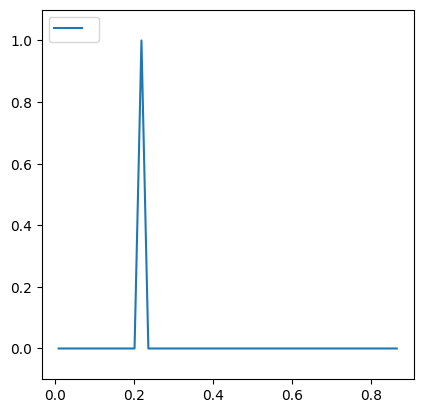

In [10]:
# ploting the unkown's initial distribution
print('Initial distribution')
viewer = Viewer(vars = (yInit),
                datamin = yInit.min()-.1,
                datamax = yInit.max()+.1)
viewer.plot()

In [11]:
# defining the time-step update function
def advectAndDiffuse1(y, dt):
    eq.solve(var=y, dt=dt)

In [12]:
# displaying some parameters
print('delX (km) = ', delX, '\n'
      'nx = ', nx, '\n'
      'dx (km) = ', dx, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells, '\n'
      'Cr (-) = ', Cr, '\n'
      'u (km/h) = ', u, '\n'
      'dtAdv = ', timeSTR(dtAdv), '\n'
      'Fr (-) = ', Fr, '\n'
      'D (km**2/h) = ', D, '\n'
      'dtDiff = ', timeSTR(dtDiff), '\n'
      'dt = min(dtAdv,dtDiff) = ', timeSTR(dt), '\n'
      'delT = ', timeSTR(delT), '\n'
      'stepsNbr = ', stepsNbr)

delX (km) =  0.875 
nx =  50 
dx (km) =  0.0175 
cellsNbr =  50 
Cr (-) =  0.2 
u (km/h) =  0.0931 
dtAdv =  0:02:15 
Fr (-) =  0.4 
D (km**2/h) =  0.003828125 
dtDiff =  0:01:55 
dt = min(dtAdv,dtDiff) =  0:01:55 
delT =  8 days, 8:00:00 
stepsNbr =  200


In [13]:
# iterate in time
for step in range(stepsNbr):
    eq.solve(var=y, dt=dt)

Distribution after 6:24:00


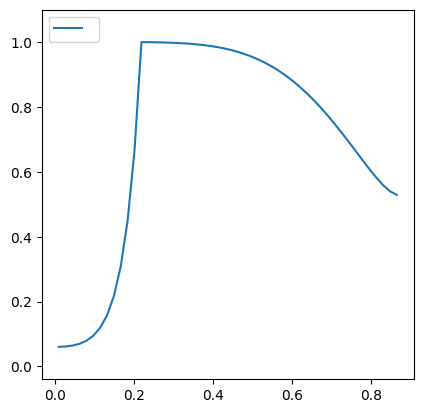

In [14]:
# ploting the unkown's final distribution
print('Distribution after', timeSTR(dt*stepsNbr))
viewer = Viewer(vars = (y),
                datamin = y.min()-.1,
                datamax = y.max()+.1)
viewer.plot()